2022-01-08 15:52:36.996512: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-08 15:52:51.041042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2022-01-08 15:52:51.071154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9649 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1f:00.0, compute capability: 7.5
2022-01-08 15:52:51.073824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 1, 1, 2048)        42658176  
                                                                 
 FC (Flatten)                (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________
Epoch 1/32


2022-01-08 15:53:04.127298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


25/25 [==============================] - 11s 128ms/step - loss: 2.4675 - acc: 0.6087 - val_loss: 1.5464 - val_acc: 0.6500
Epoch 2/32
25/25 [==============================] - 1s 51ms/step - loss: 2.3341 - acc: 0.6612 - val_loss: 1.3641 - val_acc: 0.6250
Epoch 3/32
25/25 [==============================] - 1s 53ms/step - loss: 2.1003 - acc: 0.6800 - val_loss: 1.5960 - val_acc: 0.6450
Epoch 4/32
25/25 [==============================] - 1s 51ms/step - loss: 2.1221 - acc: 0.6562 - val_loss: 1.6438 - val_acc: 0.6950
Epoch 5/32
25/25 [==============================] - 1s 51ms/step - loss: 2.1272 - acc: 0.6888 - val_loss: 1.6810 - val_acc: 0.6950
Epoch 6/32
25/25 [==============================] - 1s 52ms/step - loss: 2.0948 - acc: 0.6775 - val_loss: 1.9439 - val_acc: 0.6350
Epoch 7/32
25/25 [==============================] - 1s 49ms/step - loss: 1.8857 - acc: 0.6775 - val_loss: 2.1788 - val_acc: 0.6550
Epoch 8/32
25/25 [==============================] - 1s 51ms/step - loss: 1.8616 - acc: 0.716

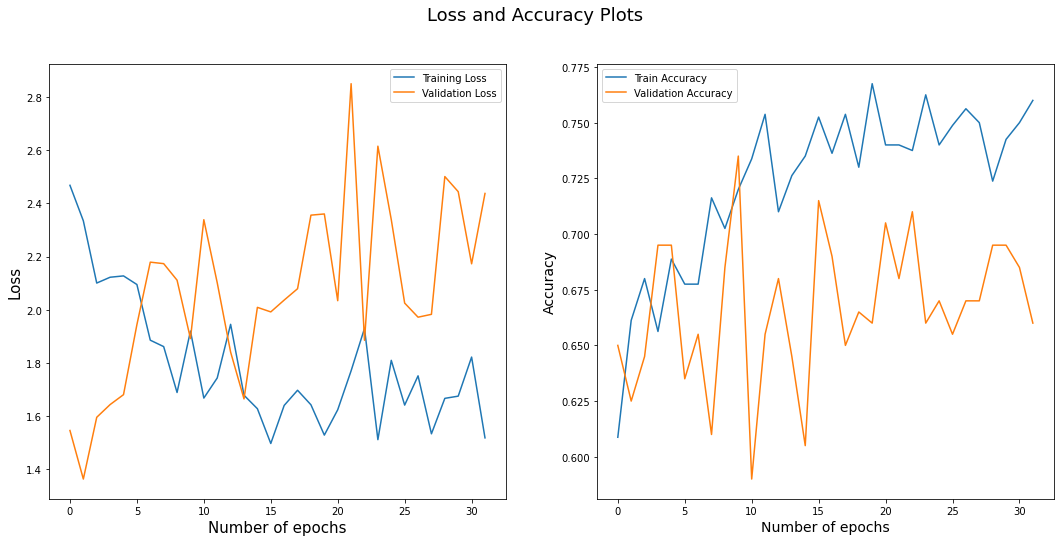

7/7 [==============================] - 2s 34ms/step
0.805


In [1]:
import os
os.environ['VISIBLE_CUDA_DEVICES'] = '0'
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.python import keras


import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.utils import Sequence
# from tensorflow.python.keras.utils.data_utils import Sequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

np.random.seed(0)

(X_c, y_c), (X_test_c, y_test_c) = cifar100.load_data()

fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

def label_shiftting(y, p = 0.2):
    L0 = np.where(y == 0)[0]
    L1 = np.where(y == 1)[0]
    A0 = np.random.choice(500, size=int(500*p), replace=False)
    A1 = np.random.choice(500, size=int(500*p), replace=False)
    y[L0[A0]] = 1
    y[L1[A1]] = 0
    return y, L0[A0], L1[A1]

X = []
y = []
for i,x in enumerate(X_c):
    if fine_label_list[y_c[i][0]] == 'caterpillar':
        X.append(x)
        y.append(0)
    elif fine_label_list[y_c[i][0]] == 'worm':
        X.append(x)
        y.append(1)
        
X_test = []
y_test = []
for i,x in enumerate(X_test_c):
    if fine_label_list[y_test_c[i][0]] == 'caterpillar':
        X_test.append(x)
        y_test.append(0)
    elif fine_label_list[y_test_c[i][0]] == 'worm':
        X_test.append(x)
        y_test.append(1)

X = np.array(X)
y = np.array(y)

y_shifted, L01, L10 = label_shiftting(y.copy(), p = 0.2)
y_shifted = to_categorical(y_shifted, 2)

X_test = np.array(X_test)
y_test = np.array(y_test)


#---Train---
from tensorflow.compat.v1.keras.applications import ResNet101

res = ResNet101(weights='imagenet', include_top = False, classes = 2, input_shape=(32,32,3))


model = Sequential()
model.add(res)
# model1.add(GlobalAveragePooling2D(name='GAP'))
model.add(Flatten(name='FC'))
# 
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax', name='dense'))
res.trainable = False
model.summary()

lr = 1e-3
sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

hist = model.fit(x=X, y=y_shifted, batch_size=32, epochs=32, verbose=1, callbacks=None, validation_split=0.2, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(hist.history['acc'], label='Train Accuracy')
plt.plot(hist.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
print(accuracy_score(y_test, y_pred))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 1, 1, 2048)        42658176  
                                                                 
 FC (Flatten)                (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________
Epoch 1/32
25/25 [==============================] - 7s 120ms/step - loss: 1.3654 - acc: 0.7725 - val_loss: 0.6063 - val_acc: 0.8850
Epoch 2/32
25/25 [====================

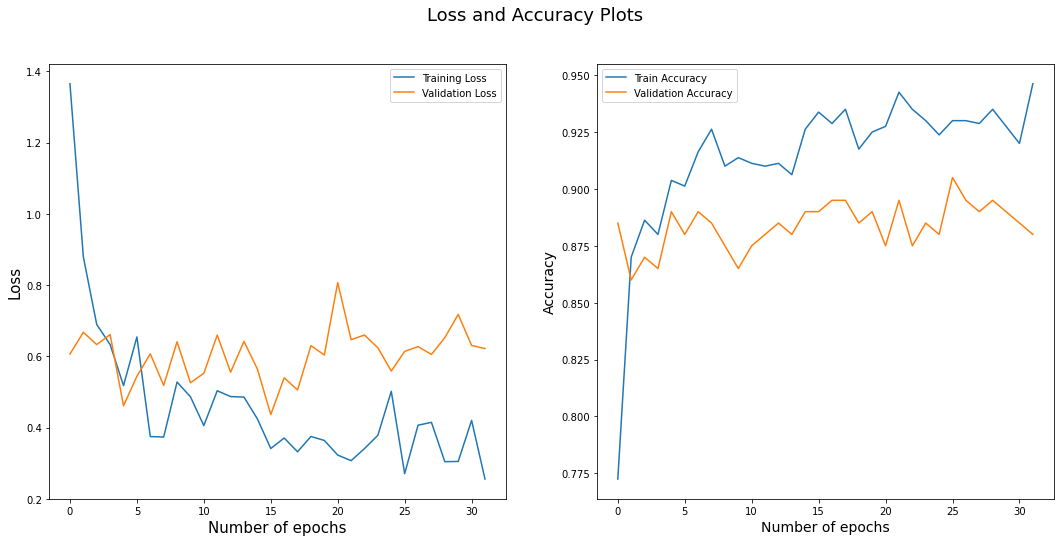

7/7 [==============================] - 2s 32ms/step
0.935


In [2]:
model = Sequential()
model.add(res)
# model1.add(GlobalAveragePooling2D(name='GAP'))
model.add(Flatten(name='FC'))
# 
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax', name='dense'))
res.trainable = False
model.summary()

lr = 1e-3
sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

# use true labels
hist = model.fit(x=X, y=to_categorical(y, 2), batch_size=32, epochs=32, verbose=1, callbacks=None, validation_split=0.2, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(hist.history['acc'], label='Train Accuracy')
plt.plot(hist.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
print(accuracy_score(y_test, y_pred))

Files already downloaded and verified


2022-01-09 03:57:16.968398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 03:57:19.470495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9157 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 1, 1, 2048)        42658176  
                                                                 
 FC (Flatten)                (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________
Epoch 1/32


2022-01-09 03:57:27.961902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


260/260 [==============================] - 21s 55ms/step - loss: 1.2929 - acc: 0.6413 - val_loss: 0.6419 - val_acc: 0.7437
Epoch 2/32
260/260 [==============================] - 12s 47ms/step - loss: 0.8814 - acc: 0.6874 - val_loss: 0.6048 - val_acc: 0.7437
Epoch 3/32
260/260 [==============================] - 12s 46ms/step - loss: 0.7567 - acc: 0.7038 - val_loss: 0.6296 - val_acc: 0.7182
Epoch 4/32
260/260 [==============================] - 12s 47ms/step - loss: 0.7008 - acc: 0.7132 - val_loss: 0.5872 - val_acc: 0.7486
Epoch 5/32
260/260 [==============================] - 13s 49ms/step - loss: 0.6761 - acc: 0.7162 - val_loss: 0.5244 - val_acc: 0.7731
Epoch 6/32
260/260 [==============================] - 13s 50ms/step - loss: 0.6572 - acc: 0.7163 - val_loss: 0.5251 - val_acc: 0.7683
Epoch 7/32
260/260 [==============================] - 13s 49ms/step - loss: 0.6232 - acc: 0.7207 - val_loss: 0.5300 - val_acc: 0.7596
Epoch 8/32
260/260 [==============================] - 13s 49ms/step - los

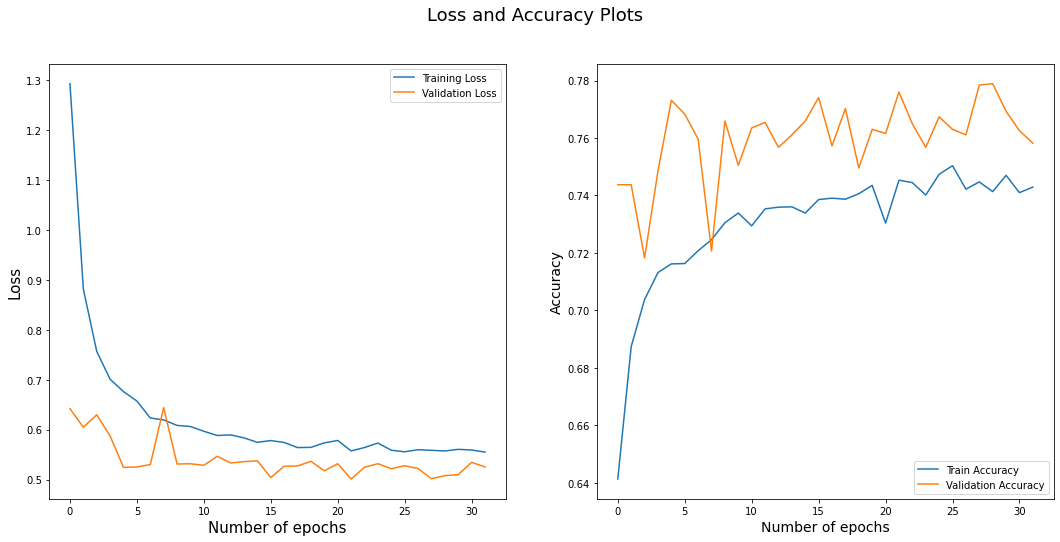

63/63 [==============================] - 4s 39ms/step
0.7815


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

import tensorflow as tf

from tensorflow.python import keras


import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.utils import Sequence
# from tensorflow.python.keras.utils.data_utils import Sequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from data.datasets import input_dataset

np.random.seed(0)

# (X_c, y_c), (X_test_c, y_test_c) = cifar100.load_data()
# real-world cifar10 dataset
noise_label = torch.load('./data/CIFAR-10_human.pt')
clean_label = noise_label['clean_label']
worst_label = noise_label['worse_label']
aggre_label = noise_label['aggre_label']
random_label1 = noise_label['random_label1']
random_label2 = noise_label['random_label2']
random_label3 = noise_label['random_label3']

train_dataset,test_dataset,num_classes,num_training_samples = input_dataset('cifar10', 'clean', './data/CIFAR-10_human.pt', True)
X_c = train_dataset.train_data
y_c = aggre_label
X_test_c = test_dataset.test_data
y_test_c = test_dataset.test_labels

fine_label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def label_shiftting(y, p = 0.2):
    L0 = np.where(y == 0)[0]
    L1 = np.where(y == 1)[0]
    A0 = np.random.choice(500, size=int(500*p), replace=False)
    A1 = np.random.choice(500, size=int(500*p), replace=False)
    y[L0[A0]] = 1
    y[L1[A1]] = 0
    return y, L0[A0], L1[A1]
 
X = []
y = []
for i,x in enumerate(X_c):
    if fine_label_list[y_c[i]] == 'automobile':
        X.append(x)
        y.append(0)
    elif fine_label_list[y_c[i]] == 'truck':
        X.append(x)
        y.append(1)
        
X_test = []
y_test = []
for i,x in enumerate(X_test_c):
    if fine_label_list[y_test_c[i]] == 'automobile':
        X_test.append(x)
        y_test.append(0)
    elif fine_label_list[y_test_c[i]] == 'truck':
        X_test.append(x)
        y_test.append(1)

X = np.array(X)
y = np.array(y)
# y_shifted, L01, L10 = label_shiftting(y.copy(), p = 0.2)
y_shifted = to_categorical(y.copy(), 2)

X_test = np.array(X_test)
y_test = np.array(y_test)


#---Train---
from tensorflow.compat.v1.keras.applications import ResNet101

res = ResNet101(weights='imagenet', include_top = False, classes = 2, input_shape=(32,32,3))


model = Sequential()
model.add(res)
# model1.add(GlobalAveragePooling2D(name='GAP'))
model.add(Flatten(name='FC'))
# 
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax', name='dense'))
res.trainable = False
model.summary()

lr = 1e-4
sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

hist = model.fit(x=X, y=y_shifted, batch_size=32, epochs=32, verbose=1, callbacks=None, validation_split=0.2, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(hist.history['acc'], label='Train Accuracy')
plt.plot(hist.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
print(accuracy_score(y_test, y_pred))